## Installation

When working within Google Colab, additional packages is necessary to take full advantage of the library. To install these, execute the following command:

In [1]:
%pip install mrcfile tensorflow-graphics umap-learn wandb ipyvolume -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.2/688.2 kB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
%pip install tensorflow_similarity -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.4/230.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


To begin using the dataset with our codebase in Colab, you first need to download it to your environment. In this tutorial, we'll proceed under the assumption that the dataset is stored on Google Drive. The following steps will guide you through the process of transferring the dataset from Google Drive to the local disk space provided by Colab:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DRIVE = "/content/drive/MyDrive/protein-reconstruction/data/data/ribsome_synthetic/"
DATASET_PATH = ""

In [5]:
# The path pointed to cryoforum packages
ROOT_DIR = '/content/drive/MyDrive/protein-reconstruction/cryoforum/'

In [6]:
!cp {DRIVE}70S_ctf_128.mrcs .
!cp {DRIVE}70S_ctf_128.star .
!cp {DRIVE}X_ctf.npy .
!cp {DRIVE}y_ctf.npy .
!cp {DRIVE}indices.npz .

> If you're executing this on a local machine, you should directly specify the path to where your dataset resides by setting the `DATASET_PATH`. For instance, if your dataset is located in the directory `/home/username/cryoforum/data/ribsome_synthetic/`, you would assign this path to the variable like so: `DATASET_PATH = "/home/username/cryoforum/data/ribsome_synthetic/"`.

## Generate the datasets

In [7]:
import mrcfile
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

sys.path.append(ROOT_DIR)

from cryoem.utils_ascep import visualise_images, Starfile
from cryoem.helpers import projections_preprocessing

In [8]:
!cp {DRIVE}70SRibosome_vol.mrc .

To create a synthetic dataset, the `RELION` software can be used to project a 3D density map into a series of 2D images using uniformly distributed orientations, which are calculated based on the HEALPix framework. The command for this process is as follows:

```python
relion_project --i 70SRibosome_vol.mrc --nr_uniform 5000 --angpix 2.86
```

In this command, you can customize various parameters to fit your requirements:

- Replace `70SRibosome_vol.mrc` with the name of your volume file.
- Change `5000` to your preferred number of projection images.
- Modify the pixel size `2.86` to match the resolution of your input data.

Upon execution, this code will generate two output files: `proj.star`, which contains the metadata of the projections, and `proj.mrcs`, which holds the generated clean projection images.

We can apply the Contrast Transfer Function (CTF) to each image in Fourier space by using the following `RELION` commands:


```python
relion_star_handler --i proj.star --add_column rlnDefocusU --add_column_value 21580.0
relion_star_handler --i out.star --add_column rlnDefocusV --add_column_value 21580.0
relion_star_handler --i out.star --add_column rlnDefocusAngle --add_column_value 0.0
relion_project --i 70SRibosome_vol.mrc --ang 70S_ctf_128.star --ctf
```

To enhance clarity and provide explicit guidance on the process of applying the Contrast Transfer Function (CTF) to each image in Fourier space, the given instructions could be restructured as follows:

We can apply the Contrast Transfer Function (CTF) to each image in Fourier space by using the following `RELION` commands:

```python
relion_star_handler --i proj.star --add_column rlnDefocusU --add_column_value 21580.0
relion_star_handler --i proj.star --add_column rlnDefocusV --add_column_value 21580.0
relion_star_handler --i proj.star --add_column rlnDefocusAngle --add_column_value 0.0
relion_project --i 70SRibosome_vol.mrc --ang proj.star --ctf
```

This sequence of commands completes the following tasks:

1. Adds a column for `rlnDefocusU` with a uniform value of `21580.0` to the metadata file `proj.star`.
2. Inserts a column for `rlnDefocusV`, also with the value `21580.0`, to the same star file.
3. Appends a column for `rlnDefocusAngle` set at `0.0` degrees.

Finally, `relion_project` is called again to multiply each image by the CTF in Fourier space, using the updated metadata file.

You should adjust the defocus values (`21580.0`) and the angle (`0.0`) according to the specifics of your experiment or data requirements. Please note that the input for the `--ang` parameter in the final `relion_project` command should match the filename of the metadata `.star` file after it has been updated with the defocus values.

Load the dataset into a Pandas `DataFrame` to proceed with data manipulation and convert the unit of Euler angles to radian:

In [9]:
s = Starfile.load(DATASET_PATH+'70S_ctf_128.star')
df = s.df

theta1 = df['_rlnAngleRot'].astype(float).values/360*2*np.pi
theta2 = df['_rlnAngleTilt'].astype(float).values/360*2*np.pi
theta3 = df['_rlnAnglePsi'].astype(float).values/360*2*np.pi

angles_true = np.stack((theta3, theta2, theta1), axis=-1)

Load the projection data into the working environment:

In [10]:
mrc = mrcfile.open(DATASET_PATH+'70S_ctf_128.mrcs')
proj = mrc.data

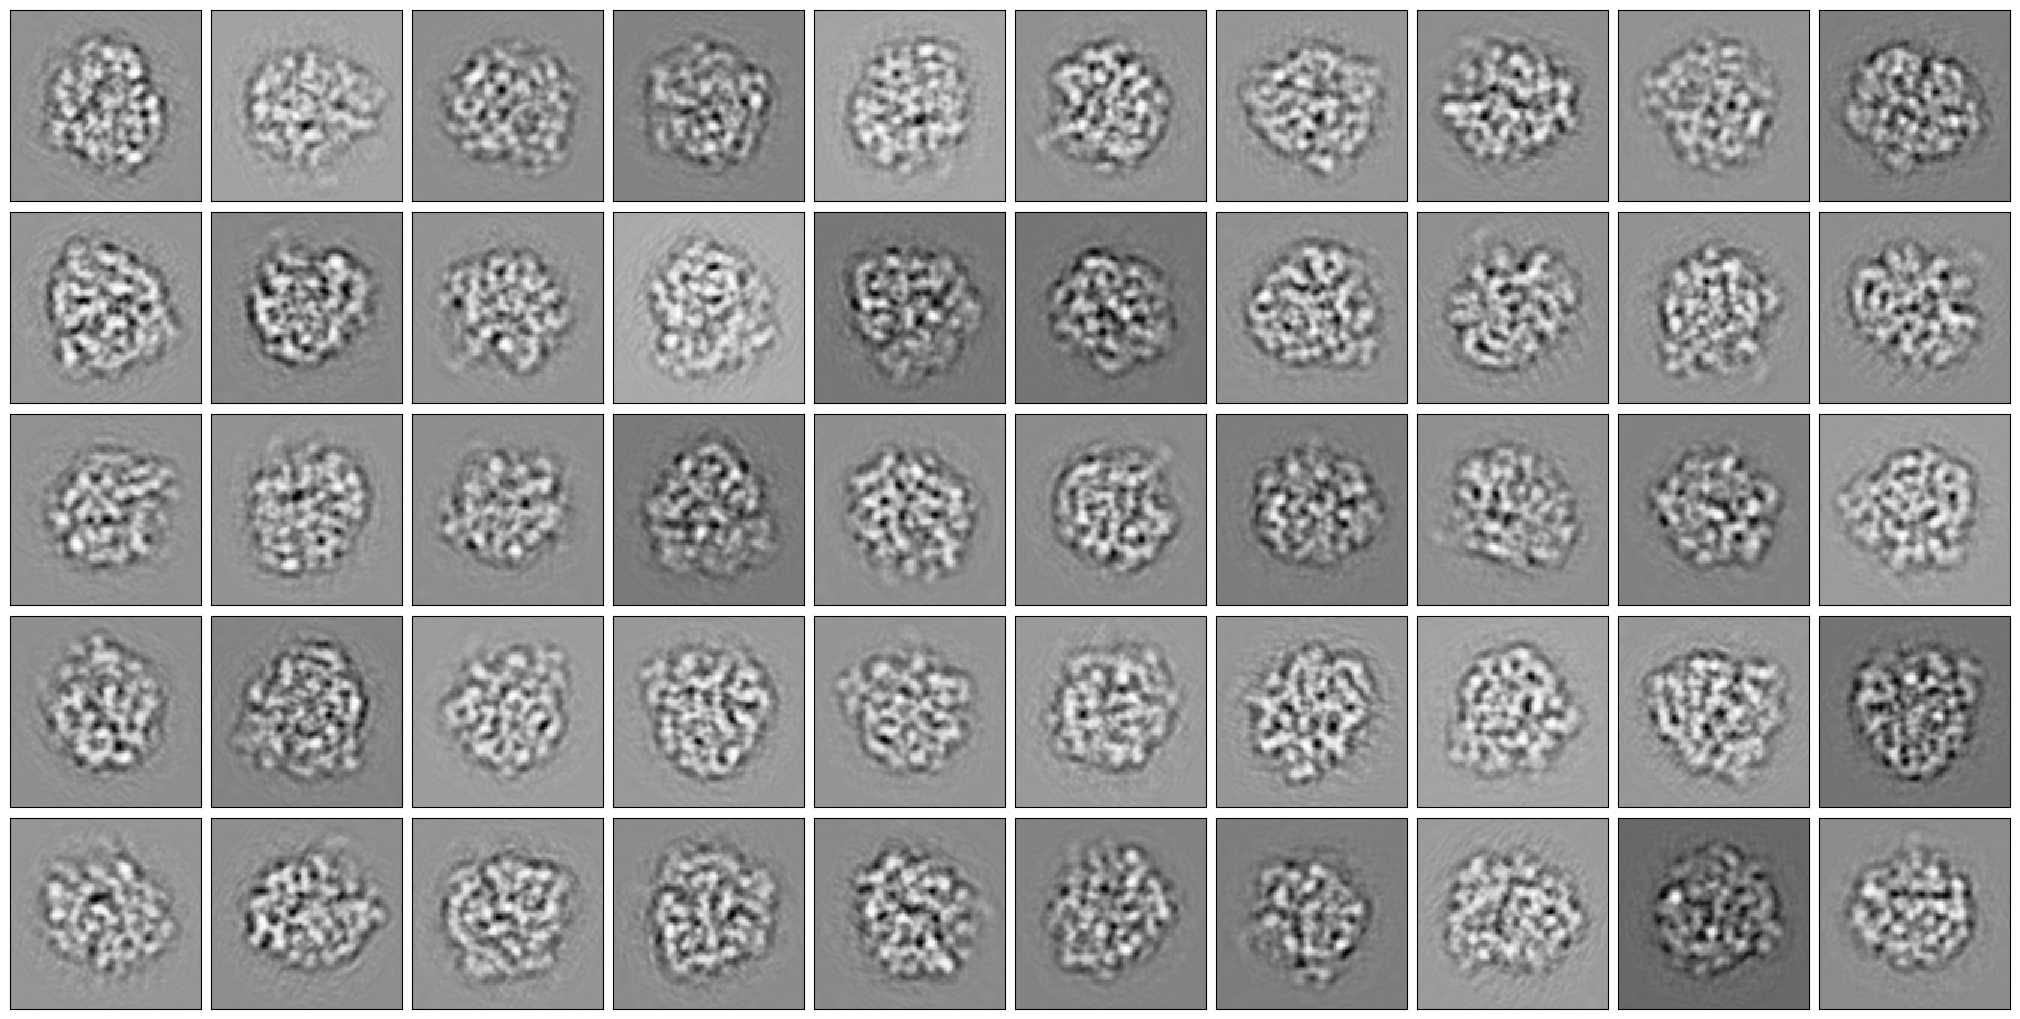

In [13]:
visualise_images(proj, 50 , 10, False)

Complete your data preprocessing by applying random translations to the projections on the `x` and `y` axes. Then, to simulate real experimental conditions, superimpose i.i.d. Gaussian noise onto the clean projection data. This step enhances the realism of your dataset by reflecting the variations and uncertainties present in actual experimental data:

In [14]:
snr = 0.1 # Adjust if needed
noise_var = proj.var()/snr
noise_var

64.66102123260498

Here, the Gaussian distribution is used to model potential residual after particle picking:

In [15]:
settings = dict(
    noise={"variance":noise_var},
    shift={"mu":0,
           "sigma":0},
    channels="gray"
)

In [16]:
X, y = projections_preprocessing(proj, angles_true, settings=settings)

{'noise': {'variance': 64.66102123260498}, 'shift': {'mu': 0, 'sigma': 0}, 'channels': 'gray'}
Image shape: (128, 128)
Data Type: float32
***
Mean: 0.000 | Std: 8.433
Min:  -49.963 | Max: 52.385
Mean: -0.000 | Std: 1.000
Min:  -5.925 | Max: 6.212


Adjust the magnitude of the shifts and the signal-to-noise ratio (SNR) to experiment with various configurations. After applying these changes, visualize the resulting images to assess the impact of different noise and shift levels on the projections:

In [18]:
visualise_images(X.squeeze(), 50 , 10, False)

Output hidden; open in https://colab.research.google.com to view.

After ensuring the synthetic data meets our expectation, we can proceed to save it to disk. It is important to also save a file, named `indices.npz`, which contains the indices used for training and validation splits. This step is crucial for ensuring the reproducibility of our experiments:

In [ ]:
np.save('X_ctf.npy', X)
np.save('y_ctf.npy', y)

In [ ]:
DATA_PATH = "/content/drive/MyDrive/protein-reconstruction/data/"

In [ ]:
!cp X_ctf.npy {DATA_PATH}
!cp y_ctf.npy {DATA_PATH}
!cp indices.npz {DATA_PATH}

## Learning the Orientation Recovery Function

Next, we'll import the necessary packages into our working environment. This sets the stage for utilizing the functionalities these packages offer throughout our script:

In [19]:
%load_ext autoreload
%autoreload 2

In [20]:
import os
from time import strftime
import pathlib
import io
import pandas as pd
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import wandb
import mrcfile

sys.path.append(ROOT_DIR)

# From the code base
from cryoem.conversions import quaternion2euler, euler2quaternion, d_q, SO3_to_s2s2, s2s2_to_SO3, matrix2quaternion, euler2matrix, matrix2euler, euler2matrix
from cryoem.plots import plot_dP_dQ
from cryoem.helpers import train_val_test_split, projections_preprocessing, OneCycleLr, visualise_images, AttrDict, convert_Avec_to_A_psd, convert_Avec_to_A, DataGenerator_SO3, WeightAdjuster,\
                convert_Avec_to_A, convert_Avec_to_A_psd, WeightAdjuster, find_learning_rate, plot_lr_vs_loss, window_mask
from cryoem.layers import BlurLayer, BlurLayer2, GeneralizedMeanPooling2D2
from cryoem.losses import cosine_distance, cos_dist_output_shape, d_q2, d_q3, cus_loss, cus_loss_function, cus_mae, cus_loss2, quat_chordal_squared_loss
from cryoem.utils_ascep import visualise_images, Starfile


# From the tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D, Flatten, AlphaDropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
#import tensorflow_similarity as tfsim
from tensorflow_similarity.layers import GeneralizedMeanPooling2D
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8355230684248220750
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14357954560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5344310205299459432
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


### Reading the data

Begin by loading the images and establishing the hyperparameters for the project. A custom `AttrDict` class has been implemented to create a configuration structure. This allows developers to modify and access configuration settings in a flexible and user-friendly manner:

In [21]:
config = dict(
    X_file = "X_ctf.npy",
    y_file = "y_ctf.npy",
    image_width = 128,
    image_height = 128,
    batch_size = 256,
    model = 'vgg_like',
    model_name = 'model_qcqp_ribosome',
    epochs = 50,
    learning_rate = 0.001,
    lr_schedule = '1cycle',
    optimizer = 'adam',
    L2_reg = 0.001,
    Drop_rate = 0.3,
    Sampler = 'random',
    Sample_percent_train = 0.01,
    Sample_percent_val = 0.01,
    BlurType = 1,
    loss_fn = 'QCQP_dist',
    Weight_schedule = True,
    exp_const = 0.5,
    gap_exp_const = 6.0,
    window = True,
    norm = True,
    log = False,
    flatten = 3
)

The parameters provided are outlined with their respective meanings below:

- **`X_file`**: File containing the 2D Cryo-EM images.
- **`y_file`**: File with the ground truth Euler angles in radians.
- **`image_width`**: Specifies the width of the images.
- **`image_height`**: Specifies the height of the images.
- **`batch_size`**: Size of the batches used during training. A larger batch size may be beneficial for contrastive learning.
- **`model`**: The architecture to be used for the model. Currently defaults to a VGG-like network as the backbone and is not configurable.
- **`model_name`**: Designation for the trained model, used when saving to disk.
- **`learning_rate`**: The initial learning rate for training.
- **`lr_schedule`**: The strategy for learning rate scheduling; a one-cycle policy is standard for achieving superconvergence.
- **`optimizer`**: Defines the optimizer, with the option to switch to `RMSProp`.
- **`L2_reg`**: The L2 regularization parameter, which imposes penalties on weight magnitudes. If overfitting is observed, increase this value; if the model underfits the training data, reduce it.
- **`Drop_rate`**: The dropout rate, a regularization technique used in network layers to prevent overfitting. Elevate this rate if overfitting is detected, or lower it to allow the model to better fit the training data.
- **`Sampler`**: Selects the sampling method for creating training pairs, with options of `random` or `uniform`. Empirical evidence suggests that the `uniform` option tends to yield better results with real datasets.
- **`Sample_percent_train`**: The fraction of total pairs allocated for the training set.
- **`Sample_percent_val`**: The fraction of total pairs allocated for the validation set.
- **`BlurType`**: The type of preprocessing layer; `0` for none, `1` for a low-pass filter, and `2` for Gaussian blurring.
- **`loss_fn`**: Specifies the loss function; options include `Q_dist` for quaternion distances, `S2S2_dist` for 6D angle representation, and `QCQP_dist` for our modified QCQP approach.
- **`Weight_schedule`**: Activates beta scheduling for balancing two different loss functions when set to `True`. It is recommended to keep this setting as `True`.
- **`exp_const`**: Adjusts the exponent constant for weight scheduling. Increase this value to emphasize the importance of pair-wise distance in the early iterations of training.
- **`gap_exp_const`**: Determines the behavior of the `GeneralizedMeanPooling2D` layer. As `gap_exp_const` approaches infinity, the pooling becomes more like max pooling, whereas a value close to 1 yields average pooling.
- **`window`**: Enables a windowing function on the images to mitigate background noise when set to `True`. It is advisable to maintain this setting as `True`.
- **`norm`**: Standardizes images before training if `True`. We suggest to remain `True`.
- **`log`**: Activates Weights and Bias logging of training information if `True`.
- **`flatten`**: Determines the layer between the CNN backbone and regression head; `0` for flattening, `1` for Global Max Pooling, `2` for combining Global Max and Average Pooling, and `3` for Generalized Mean Pooling.

> If memory limitations are encountered, consider decreasing the batch size to `128` or `64` to alleviate the issue

In [22]:
config = AttrDict(config)
# Initialize the W&B run if needed
if config.log:
  wandb.login()
  from wandb.keras import WandbCallback
  run = wandb.init(project='vgg_exp', config=config, job_type='train', reinit=True, entity="sabid")
  config = wandb.config

In [23]:
config

{'X_file': 'X_ctf.npy',
 'y_file': 'y_ctf.npy',
 'image_width': 128,
 'image_height': 128,
 'batch_size': 256,
 'model': 'vgg_like',
 'model_name': 'model_qcqp_ribosome',
 'epochs': 50,
 'learning_rate': 0.001,
 'lr_schedule': '1cycle',
 'optimizer': 'adam',
 'L2_reg': 0.001,
 'Drop_rate': 0.3,
 'Sampler': 'random',
 'Sample_percent_train': 0.01,
 'Sample_percent_val': 0.01,
 'BlurType': 1,
 'loss_fn': 'QCQP_dist',
 'Weight_schedule': True,
 'exp_const': 0.5,
 'gap_exp_const': 6.0,
 'window': True,
 'norm': True,
 'log': False,
 'flatten': 3}

We begin by loading the Cryo-EM images and the corresponding ground truth angles. Subsequently, the angles are converted into 3D rotation matrices, facilitating easier computation of loss across differing angle representations:

In [24]:
X = np.load(DATASET_PATH+config.X_file)
y = np.load(DATASET_PATH+config.y_file)

In [25]:
y = euler2matrix(y)
y = y.numpy()

We load predefined splits for training, validation, and testing to enhance reproducibility. Alternatively, you can exclude the `file_name` parameter to create new splits for different datasets:

In [26]:
train_idx, val_idx, test_idx = train_val_test_split(indices=range(X.shape[0]), file_name=DATASET_PATH+"indices.npz")

In [27]:
len(train_idx), len(val_idx), len(test_idx)

(2512, 838, 1650)

In [28]:
X.shape, y.shape

((5000, 128, 128, 1), (5000, 3, 3))

Visualize the raw images by employing the `visualise_images()` function:

In [29]:
visualise_images(X.squeeze(), 50 , 10, False)

Output hidden; open in https://colab.research.google.com to view.

Prior to training, we preprocess the images using the following steps:

In [30]:
if config.window:
  X = X.squeeze()
  X = X*window_mask(config.image_height, 0.85, 0.99)
  X = np.expand_dims(X, -1)

In [31]:
if config.norm:
  X = X.squeeze()
  norm  = [np.mean(X), np.std(X)]
  X = (X - norm[0])/norm[1]
  X = np.expand_dims(X, -1)

To inspect the results of the preprocessing, visualize the preprocessed images:

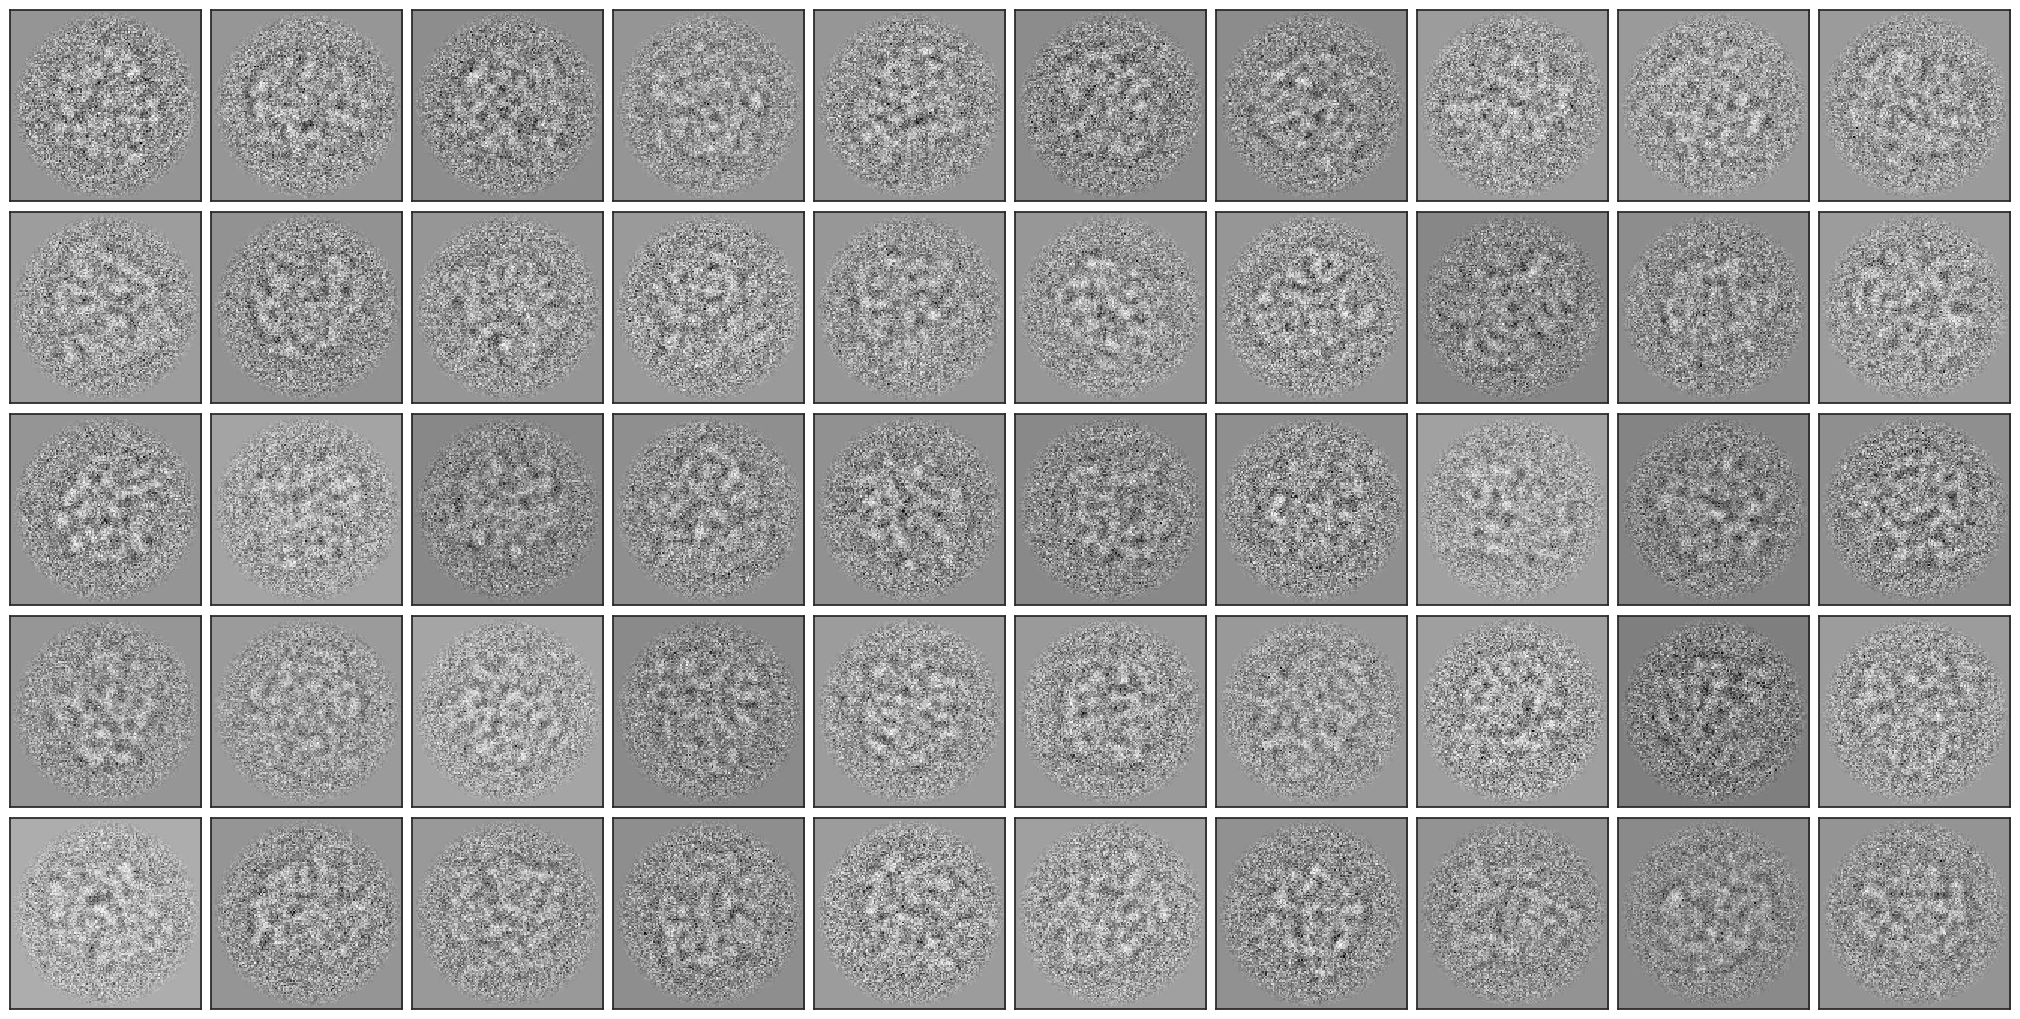

In [33]:
visualise_images(X.squeeze(), 50 , 10, False)

### Define the Model

Now that the preliminary steps are complete, it's time to define our CNN backbone and the regression head. The network architecture can be modified as needed to explore different experimental setups:

In [ ]:
model = None

def create_siamese_network_ori(input_shape, config):
    """Base network to be shared (eq. to feature extraction)."""
    l2=tf.keras.regularizers.l2(config.L2_reg)
    input_x = Input(shape=input_shape)
    if config.BlurType == 1:
      x = BlurLayer(5, config.image_width)(input_x)
    elif config.BlurType == 2:
      x = BlurLayer2(5, 11)(input_x)
    else:
      x = input_x
    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    x = Conv2D(filters=32, kernel_size=[7, 7], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(64, [5, 5], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(128, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(128, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(256, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(256, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(512, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(512, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(1024, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(1024, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    if config.flatten == 0:
      f = Flatten()(x)
    elif config.flatten == 1:
      f = tf.keras.layers.GlobalMaxPooling2D()(x)
    elif config.flatten == 2:
      f1 = tf.keras.layers.GlobalAveragePooling2D()(x)
      f2 = tf.keras.layers.GlobalMaxPooling2D()(x)
      f =  tf.keras.layers.Concatenate()([f1, f2])
    else:
      f = GeneralizedMeanPooling2D(p=config.gap_exp_const)(x)

    if config.loss_fn == "Q_dist":
      final = Dense(4, kernel_initializer='he_normal', kernel_regularizer=l2)(f)
      A = final
    elif config.loss_fn == "S2S2_dist":
      final = Dense(6, kernel_initializer='he_normal', kernel_regularizer=l2)(f)
      A = final
    elif config.loss_fn == "QCQP_dist":
      ### Gram-Schmidt Orthognalize
      x  = Dense(10, kernel_initializer='he_normal', kernel_regularizer=l2)(f)
      #c1 = tf.math.l2_normalize(x[:, :3], axis=-1)
      #c2 = tf.math.l2_normalize(x[:, 3:] - tfdot(c1,x[:, 3:])*c1, axis=-1)
      #final = tf.concat([c1,c2], axis=-1)


      ### QCQP
      A = convert_Avec_to_A_psd(x)
      _, evs = tf.linalg.eigh(A)
      final = tf.squeeze(evs[:,:,0])
      #final = tf.keras.activations.tanh(final)
      #final = tfsim.layers.ActivationStdLoggingLayer(name="out_std")(final)


    return Model(input_x, [A, final], name='cnn')

The training function is set to automatically retrieve parameters from the provided configuration structure by default:

In [ ]:
def train_siamese2(X, y, train_idx, val_idx, config, path_logs_training, training_description="", training_steps=None, validation_steps=None, plot=True, gpus=None):
    """Main method for learning the distance between two projections

    Parameters
    ----------
    X  : np.ndarray
        The array containing the projections.
    y : np.ndarray
        The array containing the ground-truth angles for every projections.
    train_idx : np.ndarray, list
        The list of training indices.
    val_idx : np.ndarray, list
        The list of validation indices.
    path_logs_training : str
        The path to logs.
    training_description : str
        Name for this training model.
    training_steps=None,
        The number of training steps.
    validation_steps=None,
        The number of validation steps.
    plot=True,
        To plot or not to plot.
    gpus=None
        Used for multi-gpu training.

    Returns
    -------
    model : keras model
        Learned distance model
    history1 : history
        Contains information about MAE, MSE losses
    """
    _idx1 = list(np.random.choice(val_idx, size=1000))
    _idx2 = list(np.random.choice(val_idx, size=1000))

    q1_true = euler2quaternion([y[i] for i in _idx1])
    q2_true = euler2quaternion([y[i] for i in _idx2])

    p1 = [X[i] for i in _idx1]
    p2 = [X[i] for i in _idx2]


    # Prepare data generators
    if config.Sampler == 'uniform':
      training_generator = DataGenerator_SO3(X, y, train_idx, config.loss_fn, limit_num_pairs=training_steps, limit_style='uniform', shuffle=True, batch_size=config.batch_size)
    else:
      training_generator = DataGenerator_SO3(X, y, train_idx, config.loss_fn, limit_num_pairs=training_steps, limit_style='random', shuffle=True, batch_size=config.batch_size)

    validation_generator = DataGenerator_SO3(X, y, val_idx, config.loss_fn, limit_num_pairs=validation_steps, limit_style='random', shuffle=False, batch_size=config.batch_size)

    input_shape = tuple(list(X.shape[1:]))
    print(f"Input images shape {input_shape}")

    # network definition
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    cnn_network = create_siamese_network_ori(input_shape, config)

    # because we re-use the same instance `cnn_network`,
    # the weights of the network will be shared across the two branches
    _, finala = cnn_network(input_a)
    _, finalb = cnn_network(input_b)

    #f = tf.keras.layers.Concatenate()([processed_a, processed_b])
    #l2=tf.keras.regularizers.l2(1e-3)
    #embed = tf.keras.layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2, use_bias=False)(f)
    #x = BatchNormalization()(embed)
    #x = tf.keras.layers.PReLU()(x)
    #x = Dropout(0.5)(x)
    #x = tf.keras.layers.Dense(4, kernel_initializer='he_normal', kernel_regularizer=l2)(x)
    #distance = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([processed_a, processed_b])

    global model
    if config.loss_fn == "QCQP_dist" or config.loss_fn == "SO3_dist" or config.loss_fn == "Q_dist" or config.loss_fn == "S2S2_dist":
      distance = Lambda(d_q3, output_shape=cos_dist_output_shape, name="distance")([finala, finalb])
      model = Model([input_a, input_b], [distance, finala, finalb])
    elif config.loss_fn == "QCQP_dist" or config.loss_fn == "SO3_dist" or config.loss_fn == "QCQP_direct" or config.loss_fn == "SO3_direct":
      model = Model([input_a, input_b], [finala, finalb])
    else:
      raise ValueError("This loss not yet implemented")
    # train
    cnn_network.summary()
    model.summary()

    # training only top layers
    #optimizer1 = RMSprop(learning_rate=learning_rate)
    optimizer1 = Adam(learning_rate=config.learning_rate, beta_2=0.99, epsilon=1e-05)
    #optimizer1 = Adam(learning_rate=learning_rate)
    if config.Weight_schedule:
      loss_weight1 = K.variable(1)
      loss_weight2 = K.variable(0)
      loss_weight3 = K.variable(0)
      loss_ws = [loss_weight1, loss_weight2, loss_weight3]

      # define the callback
      weight_adjuster = WeightAdjuster(
        loss_ws, config.epochs, config.exp_const  # Pass the weights list to callbacks
      )
      if config.loss_fn == "QCQP_dist" or config.loss_fn == "Q_dist" or config.loss_fn == "S2S2_dist":
        model.compile(loss=[cus_mae(loss_weight1), cus_loss(loss_weight2), cus_loss(loss_weight3)], optimizer=optimizer1, sample_weight_mode=None)
      elif config.loss_fn == "SO3_dist":
        model.compile(loss=[cus_mae(loss_weight1), cus_mae(loss_weight2), cus_mae(loss_weight3)], optimizer=optimizer1, sample_weight_mode=None)
    else:
      if config.loss_fn == "QCQP_dist"or config.loss_fn == "Q_dist" or config.loss_fn == "S2S2_dist":
        model.compile(loss=[keras.losses.MeanAbsoluteError(), cus_loss_function, cus_loss_function], optimizer=optimizer1, sample_weight_mode=None)
      elif config.loss_fn == "SO3_dist":
        model.compile(loss=[keras.losses.MeanAbsoluteError(), keras.losses.MeanAbsoluteError(), keras.losses.MeanAbsoluteError()], optimizer=optimizer1, sample_weight_mode=None)
      elif config.loss_fn == "QCQP_direct":
        model.compile(loss=[cus_loss_function, cus_loss_function], optimizer=optimizer1, sample_weight_mode=None)
      elif config.loss_fn == "SO3_direct":
        model.compile(loss=[keras.losses.MeanAbsoluteError(), keras.losses.MeanAbsoluteError()], optimizer=optimizer1, sample_weight_mode=None)


    one_c = OneCycleLr(max_lr=config.learning_rate, steps_per_epoch=len(training_generator), epochs=config.epochs)#, cycle_momentum=False)#, anneal_strategy='linear')
    if config.Sampler == 'uniform':
      print('uniform')
      one_c = OneCycleLr(max_lr=config.learning_rate, steps_per_epoch=len(training_generator), epochs=config.epochs)



    # Setup callbacks
    # Callback that saves the model
    training_description = training_description or strftime('%Y%m%d_%H%M%S')
    CHECKPOINT_PATH = os.path.join(f"{path_logs_training}/training", f"{training_description}.h5")
    pathlib.Path(f"{path_logs_training}/training").mkdir(parents=True, exist_ok=True)
    backup_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')
    print(f"Model will be saved to: {CHECKPOINT_PATH}")

    # Callback that will show tensorboard data
    LOGS_PATH = os.path.join(f"{path_logs_training}/logs", f"{training_description}")
    pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
    logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    #callbacks = [reduce_lr]
    #callbacks = [one_c]
    callbacks = [backup_callback, one_c]
    if config.log:
      callbacks.append(WandbCallback(save_model=True, monitor="val_loss", mode="min"))
    if config.Weight_schedule:
      callbacks.append(weight_adjuster)
    history1 = model.fit(training_generator,
                            epochs=config.epochs,
                            validation_data=validation_generator,
                            callbacks=callbacks)
                            #callbacks=[backup_callback, lr_scheduler, weight_adjuster])

    # Get training and test loss histories
    #training_loss = history1.history['loss']
    #val_loss = history1.history['val_loss']
    #pathlib.Path(f"{path_logs_training}/losses").mkdir(parents=True, exist_ok=True)
    #np.savez(f"{path_logs_training}/losses/{training_description}.npz", training_loss, val_loss, history1)

    return model, history1, one_c

#### Inspecting the Architecture

Before commencing with training, it's important to verify that the input shapes align with our expectations and the architecture is correctly configured:

In [ ]:
input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
print(f"Input images shape {input_shape}")

# network definition
input_a = Input(shape=input_shape)

cnn_network = create_siamese_network_ori(input_shape, config)
cnn_network.summary()

Input images shape (128, 128, 1)
Model: "cnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 blur_layer (BlurLayer)      (None, 128, 128, 6)          16384     ['input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         9408      ['blur_layer[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                

### Orientation Learning

Create a directory to store the trained model and associated metadata before initiating the training process:

In [ ]:
TRAINING_DIR = "70s"

In [ ]:
!mkdir {TRAINING_DIR}

> When employing `uniform` sampling, it may be necessary to adjust the `Sample_percent_train` parameter upwards to ensure an equivalent number of training pairs as would be obtained with `random` sampling. For the current dataset, a starting value of approximately 0.36 is suggested, but you should feel free to experiment with this value. Check the total number of pairs generated in the subsequent cell to fine-tune this parameter prior to training:

In [ ]:
train_percent = config.Sample_percent_train
val_percent = config.Sample_percent_val
int(train_percent*np.power(len(train_idx), 2)), int(val_percent*np.power(len(val_idx), 2))

(63101, 7022)

We are now set up to begin the training process:

In [ ]:
#0.001
model, history1, onec = train_siamese2(X=X, y=y,
                               train_idx=train_idx,
                               val_idx=val_idx,
                               config=config,
                               path_logs_training=TRAINING_DIR,
                               training_description=config.model_name,
                               training_steps=int(train_percent*np.power(len(train_idx), 2)),
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)),
                               plot=False,
                               gpus=None)

Data created in 3.29727840423584 sec
Data created in 0.35999488830566406 sec
Input images shape (128, 128, 1)
Model: "cnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 blur_layer_1 (BlurLayer)    (None, 128, 128, 6)          16384     ['input_5[0][0]']             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 128, 128, 32)         9408      ['blur_layer_1[0][0]']        
                                                                                                  
 batch_normalization_10 (Ba  (None, 128, 128, 32)         128       ['conv2d_10[0][0]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 lr:0.000050  mom:0.948924
257/257 [==============================] - 164s 514ms/step - loss: 8.7495 - distance_loss: 0.8685 - cnn_loss: 0.0000e+00 - cnn_1_loss: 0.0000e+00 - val_loss: 9.8163 - val_distance_loss: 1.9523 - val_cnn_loss: 0.0000e+00 - val_cnn_1_loss: 0.0000e+00
Epoch 2/50
257/257 [==============================] - ETA: 0s - loss: 8.6571 - distance_loss: 0.8161 - cnn_loss: 0.0000e+00 - cnn_1_loss: 0.0000e+00
Epoch 2: val_loss improved from 9.81627 to 9.74017, saving model to 70s/training/model_qcqp_ribosome.h5
 lr:0.000081  mom:0.945708
257/257 [==============================] - 126s 489ms/step - loss: 8.6571 - distance_loss: 0.8161 - cnn_loss: 0.0000e+00 - cnn_1_loss: 0.0000e+00 - val_loss: 9.7402 - val_distance_loss: 1.9280 - val_cnn_loss: 0.0000e+00 - val_cnn_1_loss: 0.0000e+00
Epoch 3/50
257/257 [==============================] - ETA: 0s - loss: 8.7761 - distance_loss: 0.7039 - cnn_loss: 0.1559 - cnn_1_loss: 0.1560
Epoch 3: val_loss improved from 9.74017 to 9.68839, sa

After the training is complete, visualize the learning rate and weight scheduling to evaluate their progression and effectiveness throughout the training process:

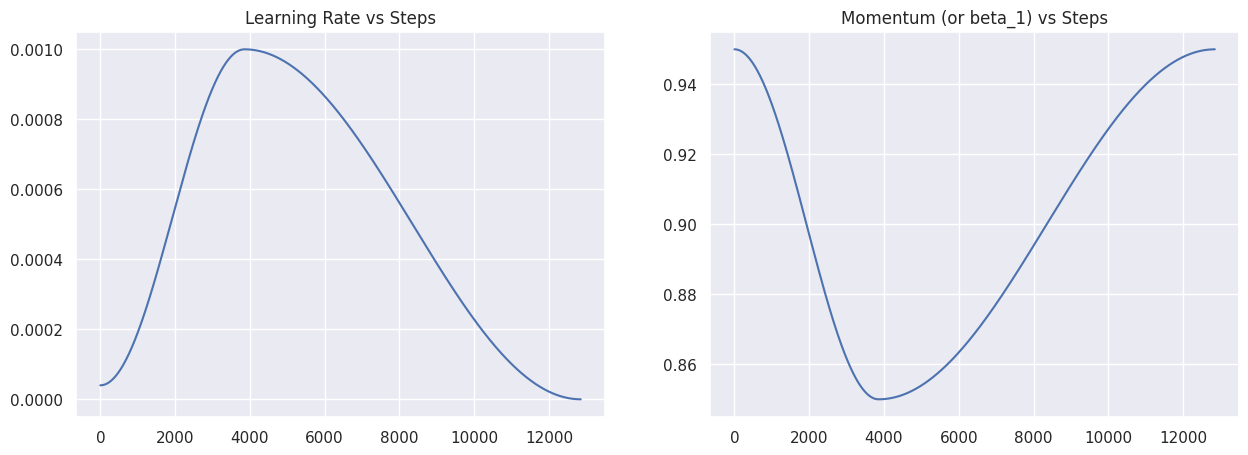

In [ ]:
sns.set_style("darkgrid", {"axes.grid":True})
onec.plot_lrs_moms()

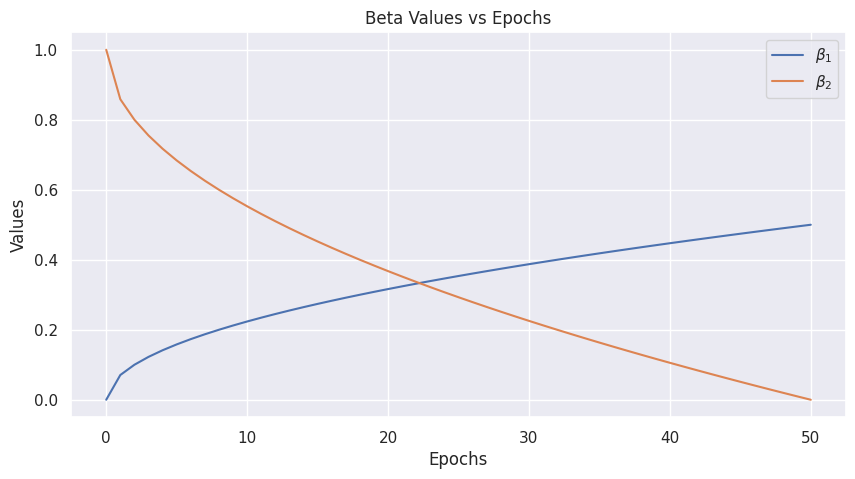

In [ ]:
# Settings
sns.set_style("darkgrid", {"axes.grid":True})
n_epochs = config.epochs  # total number of epochs
exp_const = config.exp_const  # exponential constant

epochs = np.arange(n_epochs + 1)
alpha = (epochs / n_epochs) ** exp_const
beta_1 = alpha / 2
beta_2 = 1 - alpha

# Creating a DataFrame
data = pd.DataFrame({
    'Epoch': epochs,
    'Beta_1': beta_1,
    'Beta_2': beta_2
})

# Plotting using Seaborn without melting the DataFrame
plt.figure(figsize=(10, 5))
sns.lineplot(x='Epoch', y='Beta_1', data=data, label=r'$\beta_1$')
sns.lineplot(x='Epoch', y='Beta_2', data=data, label=r'$\beta_2$')

plt.title('Beta Values vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()
plt.grid(True);

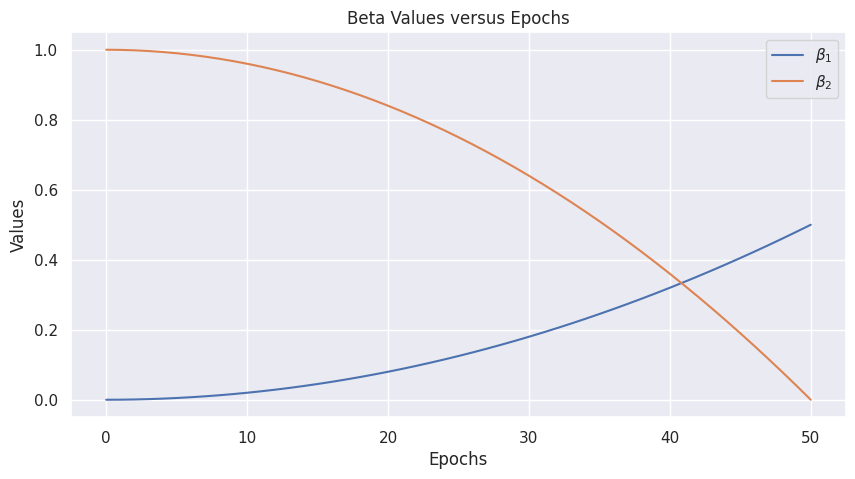

In [ ]:
# Settings
sns.set_style("darkgrid", {"axes.grid":True})
n_epochs = config.epochs  # total number of epochs
exp_const = 2  # exponential constant

epochs = np.arange(n_epochs + 1)
alpha = (epochs / n_epochs) ** exp_const
beta_1 = alpha / 2
beta_2 = 1 - alpha

# Creating a DataFrame
data = pd.DataFrame({
    'Epoch': epochs,
    'Beta_1': beta_1,
    'Beta_2': beta_2
})

# Plotting using Seaborn without melting the DataFrame
plt.figure(figsize=(10, 5))
sns.lineplot(x='Epoch', y='Beta_1', data=data, label=r'$\beta_1$')
sns.lineplot(x='Epoch', y='Beta_2', data=data, label=r'$\beta_2$')

plt.title('Beta Values versus Epochs')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()
plt.grid(True);

### Read Model Checkpoint

At this stage, we have the option to save the trained model to disk for future use, or alternatively, we can load a pre-trained model from storage:

In [ ]:
# Load pretrained model
!cp /content/drive/MyDrive/protein-reconstruction/models/model_qcqp_ribosome2.h5 /content/model_qcqp_ribosome2.h5

In [ ]:
# We can also save the model in the last iteration
# model.save(ROOT_DIR+"models/70s.h5") # one may choose to store the final model

In [ ]:
# Save the current model
# !cp {TRAINING_DIR}/training/{config.model_name}.h5 {ROOT_DIR}models/test.h5

In [ ]:
# put correct filename
#model_filename = TRAINING_DIR+"/training/"+config.model_name+".h5" # The current model
model_filename = "model_qcqp_ribosome2.h5"  # The pretrained model
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename, compile=False, custom_objects={"BlurLayer": BlurLayer})
# Show the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 cnn (Functional)            [(None, 4, 4),               2018157   ['input_3[0][0]',             
                              None]                       8          'input_4[0][0]']             
                                                                                                  
 distance (Lambda)           (None,)                      0         ['cnn[0][1]',             

## Analysis

### Performance Plot - True vs. Predicted

We now proceed to utilize the trained model to make inferences on the training, validation, and test datasets:

In [ ]:
cnn = model.layers[-2]

In [ ]:
q_pred_train = cnn.predict(X[train_idx])[1]
q_pred_val = cnn.predict(X[val_idx])[1]
q_pred_test = cnn.predict(X[test_idx])[1]

52/52 [==============================] - 2s 36ms/step


After obtaining the predictions, we can compute the error metrics using the `d_q()` function to evaluate the model's performance:

In [ ]:
#vgg s2s2 1/2
c1 = d_q(q_pred_train, matrix2quaternion(y[train_idx]))
c2 = d_q(q_pred_val, matrix2quaternion(y[val_idx]))
c3 = d_q(q_pred_test, matrix2quaternion(y[test_idx]))
np.median(c1), np.median(c2), np.median(c3), np.mean(c1), np.mean(c2), np.mean(c3)

(0.015098825033734128,
 0.06926351180949503,
 0.07647623989135682,
 0.015842869801896472,
 0.08039806233020139,
 0.08787167485393993)

In [ ]:
#https://docs.wandb.ai/guides/track/log
#run.summary["training_error_median"] = np.median(c1)
#run.summary["validation_error_median"] = np.median(c2)
#run.summary["testing_error_median"] = np.median(c3)
#run.summary["training_error_mean"] = np.mean(c1)
#run.summary["validation_error_mean"] = np.mean(c2)
#run.summary["testing_error_mean"] = np.mean(c3)
#run

In [ ]:
#config.model_name, run.dir

In [ ]:
#model.save(os.path.join(run.dir, "70s/training/"+config.model_name+".h5"))

In [ ]:
#run.finish()

#### Visulization

In this step, we will define a `d_p()` function to calculate the distances for randomly drawn pairs from the testing set and compare these calculated distances with the ground truth distances to assess accuracy:

In [ ]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=256)

In [ ]:
yy = y[test_idx]
XX = X[test_idx]

idx1 = list(np.random.choice(np.arange(1650), size=5000))
idx2 = list(np.random.choice(np.arange(1650), size=5000))

q1_true = matrix2quaternion([yy[i] for i in idx1])
q2_true = matrix2quaternion([yy[i] for i in idx2])

p1 = [XX[i] for i in idx1]
p2 = [XX[i] for i in idx2]

aa = d_p(p1, p2)

dP_values = aa[0].squeeze().T
dQ_values = d_q(q1_true, q2_true).numpy()

20/20 [==============================] - 31s 814ms/step


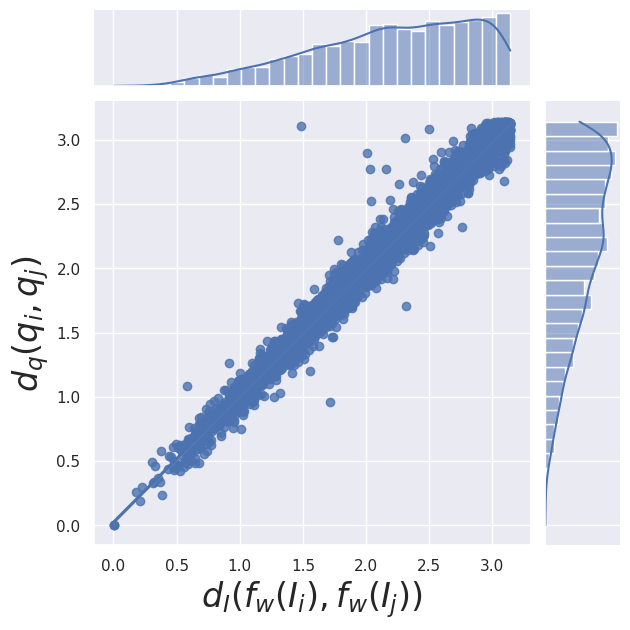

In [ ]:
sns.set_style("darkgrid", {"axes.grid":True})
cc = sns.jointplot(x=dP_values, y=dQ_values, kind='reg')
cc.set_axis_labels('$d_I(f_w(I_i), f_w(I_j))$', '$d_q(q_i,q_j)$', fontsize=24);

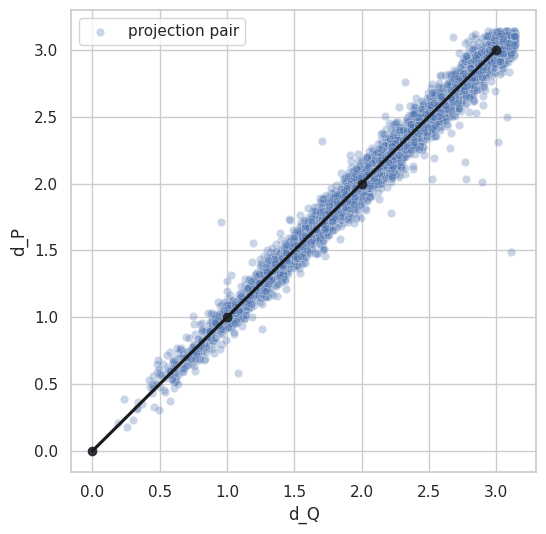

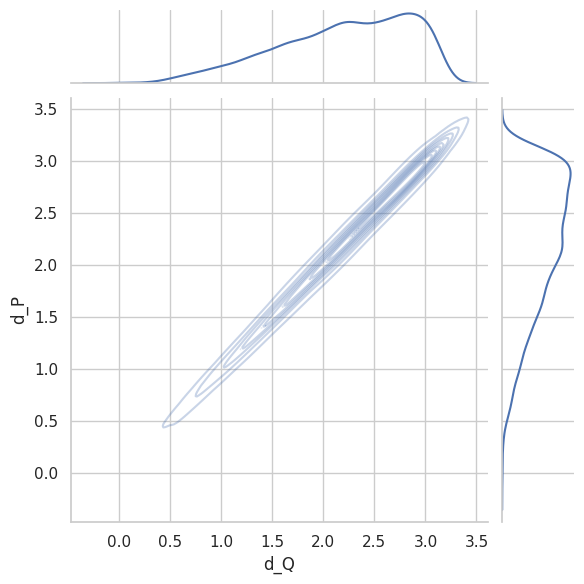

Variance = 0.08634749027886858
Min. angle recovery loss possible = 0.007454397899643814
MAE:  0.061185192


In [ ]:
plot_dP_dQ(dP_values, dQ_values)

#### Uncertainty quantification with Matrix `A`

To quantify uncertainty in our model predictions, we establish several metrics as follows:

In [ ]:
def sum_bingham_dispersion_coeff(A):
  if len(A.shape) == 2:
    A = A.reshape(1,4,4)
  els = np.linalg.eigvalsh(A)
  min_el = els[:,0]
  I = np.repeat(np.eye(4).reshape(1,4,4), A.shape[0], axis=0)
  return np.trace(-A + I*min_el[:,None,None], axis1=1, axis2=2)

def max_dispersion_coeff(A):
  if len(A.shape) == 2:
    A = A.reshape(1,4,4)
  els = np.linalg.eigvalsh(A)

  lamb1A, lamb2A, lamb3A, lamb4A = els[:,0], els[:,1], els[:,2], els[:,3]

  lamb1 = -lamb4A + lamb1A
  lamb2 = -lamb3A + lamb1A
  lamb3 = -lamb2A + lamb1A
  return np.max([lamb1, lamb2, lamb3], axis=0)

def first_eig_gap(A):
    el = np.linalg.eigvalsh(A)
    spacings = np.diff(el, axis=1)
    return spacings[:, 0]

def wigner_log_likelihood_measure(A, reduce=False):
    el, _ = np.linalg.eig(A)
    el.sort(axis=1)
    spacings = np.diff(el, axis=1)
    lls = np.log(spacings) - 0.25*np.pi*(spacings**2)
    if reduce:
        return np.sum(lls, axis=1).mean()
    else:
        return np.sum(lls, axis=1)

In [ ]:
def compute_threshold(A, uncertainty_metric_fn=first_eig_gap, quantile=0.75):
  stats = uncertainty_metric_fn(A)
  return np.quantile(stats, quantile)

In [ ]:
def _scatter(ax, x, y, title, color='tab:red', marker=".", size =4, rasterized=False):
    ax.scatter(x, y, color=color, s=size, marker=marker, label=title, rasterized=rasterized)
    return

def _create_scatter_plot(thresh, thresh_label, lls, errors, labels, xlabel, ylim=None, legend=True, ylabel=True):
    fig, ax = plt.subplots()
    fig.set_size_inches(10,6)
    ax.axvline(thresh, c='k', ls='--', lw=0.75, label=thresh_label)
    colors = ['tab:orange','grey']
    markers = ['.', '+']
    for i, (ll, error, label) in enumerate(zip(lls, errors, labels)):
        _scatter(ax, ll, error, label, color=colors[i], size=1, marker=markers[i], rasterized=True)
    if legend:
        ax.legend(loc='upper left', markerscale=5.0, fontsize=14)
    ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)
    if ylabel:
        ax.set_ylabel('Error', fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    #ax.set_yscale('log')
    #ax.set_xscale('symlog')
    #ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    ax.set_ylim(ylim)
    return fig

We will now extract the metrics from matrix `A` and compile them into a `DataFrame` for structured analysis and reporting:

In [ ]:
A_train = cnn.predict(X[train_idx])[0]
A_val = cnn.predict(X[val_idx])[0]
A_test = cnn.predict(X[test_idx])[0]

52/52 [==============================] - 2s 36ms/step


In [ ]:
lls = [max_dispersion_coeff(A_test), max_dispersion_coeff(A_train)]
lls2 = [sum_bingham_dispersion_coeff(A_test), sum_bingham_dispersion_coeff(A_train)]
lls3 = [first_eig_gap(A_test), first_eig_gap(A_train)]
lls4 = [wigner_log_likelihood_measure(A_test), wigner_log_likelihood_measure(A_train)]
errors = [d_q(q_pred_test, matrix2quaternion(y[test_idx])), d_q(q_pred_train, matrix2quaternion(y[train_idx]))]
df = pd.DataFrame([errors[0].numpy(), lls[0], lls2[0], lls3[0], lls4[0]]).T
df

0           1            2           3             4
0     0.073883  -99.005707  -553.126801   99.005707 -1.864120e+04
1     0.052869 -108.880661  -507.366608  108.880661 -1.960609e+04
2     0.169525 -137.939423  -863.398682  137.939423 -5.478065e+04
3     0.126574 -178.951660  -889.244781  178.951660 -9.165314e+04
4     0.050015 -156.206253  -832.241547  156.206253 -9.876863e+04
...        ...         ...          ...         ...           ...
1645  0.020431 -352.248779 -2518.437622  352.248779 -1.150927e+06
1646  0.014156 -147.552521  -729.223953  147.552521 -3.509072e+04
1647  0.046376 -288.633667 -1501.150879  288.633667 -3.079942e+05
1648  0.009824 -319.214111 -1610.580750  319.214111 -3.117749e+05
1649  0.074306 -319.269287 -1640.212891  319.269287 -3.854269e+05

[1650 rows x 5 columns]

In [ ]:
np.quantile(errors[0].numpy(), 0.25), np.quantile(errors[0].numpy(), 0.5), np.quantile(errors[0].numpy(), 0.75)

(0.05214745772478211, 0.07647623989135682, 0.10717730777962539)

In [ ]:
df.columns = ['error', 'max', 'trace', 'gap', 'likelihood']

In [ ]:
mybins = pd.IntervalIndex.from_tuples([(0, np.quantile(errors[0].numpy(), 0.25)),
                    (np.quantile(errors[0].numpy(), 0.25), np.quantile(errors[0].numpy(), 0.5)),
                    (np.quantile(errors[0].numpy(), 0.5), np.quantile(errors[0].numpy(), 0.75)),
                    (np.quantile(errors[0].numpy(), 0.75), 3.14)])
df['testing error'] = pd.cut(df['error'], bins = mybins)
df['testing error'] = df['testing error'].apply(lambda x: x.right)
df

error         max        trace         gap    likelihood  \
0     0.073883  -99.005707  -553.126801   99.005707 -1.864120e+04   
1     0.052869 -108.880661  -507.366608  108.880661 -1.960609e+04   
2     0.169525 -137.939423  -863.398682  137.939423 -5.478065e+04   
3     0.126574 -178.951660  -889.244781  178.951660 -9.165314e+04   
4     0.050015 -156.206253  -832.241547  156.206253 -9.876863e+04   
...        ...         ...          ...         ...           ...   
1645  0.020431 -352.248779 -2518.437622  352.248779 -1.150927e+06   
1646  0.014156 -147.552521  -729.223953  147.552521 -3.509072e+04   
1647  0.046376 -288.633667 -1501.150879  288.633667 -3.079942e+05   
1648  0.009824 -319.214111 -1610.580750  319.214111 -3.117749e+05   
1649  0.074306 -319.269287 -1640.212891  319.269287 -3.854269e+05   

     testing error  
0         0.076476  
1         0.076476  
2         3.140000  
3         3.140000  
4         0.052147  
...            ...  
1645      0.052147  
1646      0.052147  
1647      0.052147  
1648      0.052147  
1649      0.076476  

[1650 rows x 6 columns]

In [ ]:
df.describe()

error          max        trace          gap    likelihood
count  1650.000000  1650.000000  1650.000000  1650.000000  1.650000e+03
mean      0.087872  -155.377632  -880.189511   155.377632 -1.066008e+05
std       0.091113    66.667825   352.877609    66.667825  1.166555e+05
min       0.004604  -510.014221 -2771.092590     6.111664 -1.150927e+06
25%       0.052147  -191.363365 -1072.644188   107.987419 -1.340731e+05
50%       0.076476  -143.693298  -817.918610   143.693298 -6.853961e+04
75%       0.107177  -107.987419  -626.356529   191.363365 -3.493517e+04
max       2.941884    -6.111664  -134.066956   510.014221 -2.178438e+03

Next, we'll create a scatter plot to visualize the relationship between the computed statistics and the testing error:

In [ ]:
sns.set()

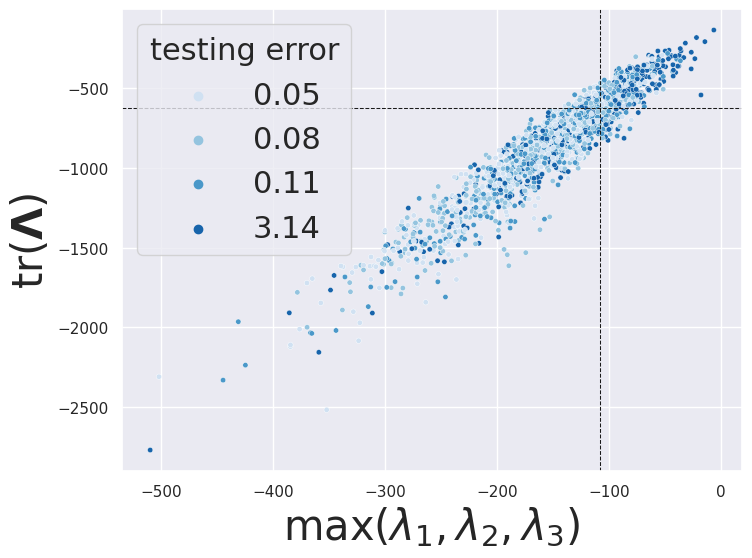

In [ ]:
# Create scatter plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data=df, x="max", y="trace", hue='testing error', palette='Blues', s=15)

# Get the current legend
ax.legend(loc=0, fontsize=22)
legend = ax.legend_
legend.set_title("testing error")
legend.get_title().set_fontsize(22)
# Modify the legend labels in-place
for text in legend.get_texts():  # Skip the first label, which is the legend title ('bins')
    value = float(text.get_text())
    new_label = "{:.2f}".format(value)  # Format with 2 decimal places
    text.set_text(new_label)


ax.axvline(df.describe().loc['75%', 'max'], c='k', ls='--', lw=0.75, label='x threshold: \n q=' + '{:.2F}'.format(0.75))
ax.axhline(df.describe().loc['75%', 'trace'], c='k', ls='--', lw=0.75, label='y threshold: \n q=' + '{:.2F}'.format(0.75))
ax.set_xlabel('$\max(\lambda_1, \lambda_2, \lambda_3)$', fontsize=30)
ax.set_ylabel('tr($\mathbf{\Lambda})$', fontsize=30)
# Show the plot
plt.show()

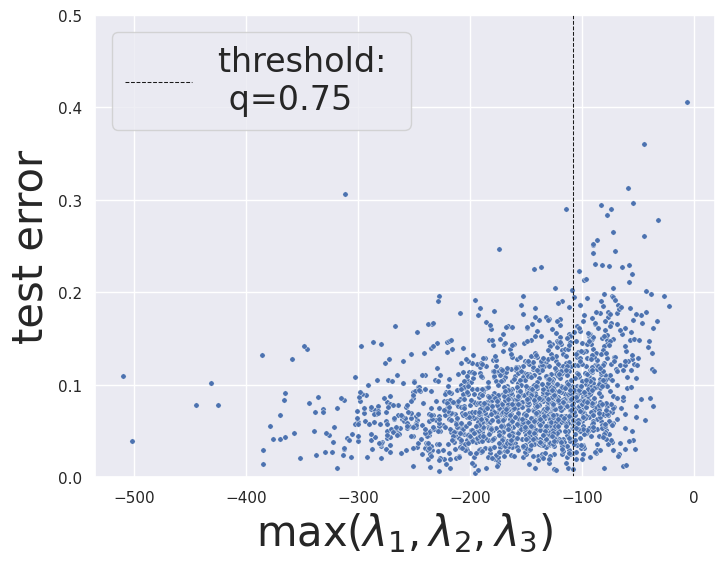

In [ ]:
# Create scatter plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data=df, x="max", y="error", s=15)

ax.axvline(df.describe().loc['75%', 'max'], c='k', ls='--', lw=0.75, label='threshold: \n q=' + '{:.2F}'.format(0.75))
ax.set_xlabel('$\max(\lambda_1, \lambda_2, \lambda_3)$', fontsize=30)
ax.set_ylabel('test error', fontsize=30)
ax.set_ylim([0, 0.5])
ax.legend(fontsize=24)
# Show the plot
plt.show()

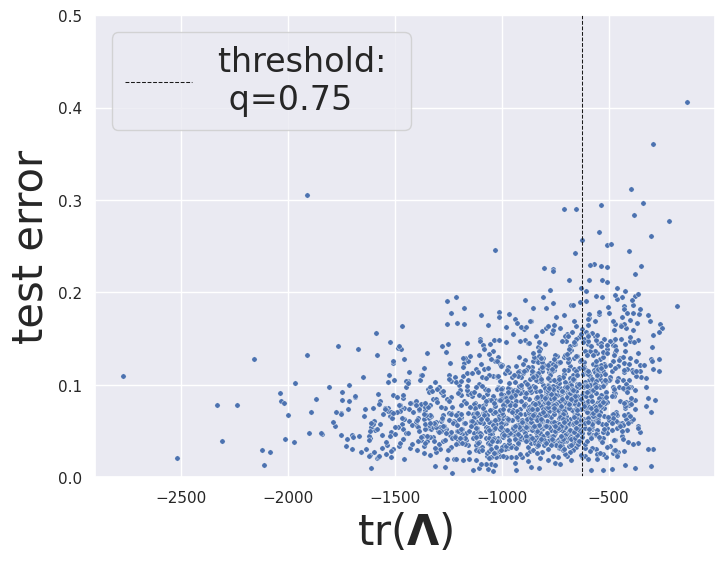

In [ ]:
# Create scatter plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data=df, x="trace", y="error", s=15)

ax.axvline(df.describe().loc['75%', 'trace'], c='k', ls='--', lw=0.75, label='threshold: \n q=' + '{:.2F}'.format(0.75))
ax.set_xlabel('tr($\mathbf{\Lambda})$', fontsize=30)
ax.set_ylabel('test error', fontsize=30)
ax.set_ylim([0, 0.5])
ax.legend(fontsize=24)
# Show the plot
plt.show()

### Filter the particles and write out star file

We can construct three distinct `DataFrames` by applying three different filtering schemes based on the Q3 quantile:

In [ ]:
filtered_df = df[(df['max'] < df.describe().loc['75%', 'max']) & (df['trace'] < df.describe().loc['75%', 'trace'])]
filtered_df.describe()

error          max        trace          gap    likelihood
count  1160.000000  1160.000000  1160.000000  1160.000000  1.160000e+03
mean      0.075950  -183.802626 -1029.068244   183.802626 -1.383897e+05
std       0.038182    58.236757   310.734709    58.236757  1.254593e+05
min       0.004604  -510.014221 -2771.092590   108.194870 -1.150927e+06
25%       0.048390  -211.379467 -1192.672218   139.870911 -1.728683e+05
50%       0.069706  -170.613335  -962.777039   170.613335 -9.534757e+04
75%       0.095674  -139.870911  -792.120148   211.379467 -5.819337e+04
max       0.305860  -108.194870  -627.133698   510.014221 -2.485678e+04

In [ ]:
filtered_df2 = df[(df['max'] < df.describe().loc['75%', 'max'])]
filtered_df2.describe()

error          max        trace          gap    likelihood
count  1237.000000  1237.000000  1237.000000  1237.000000  1.237000e+03
mean      0.076294  -179.724087 -1001.068554   179.724087 -1.315971e+05
std       0.038313    58.607200   320.062201    58.607200  1.243401e+05
min       0.004604  -510.014221 -2771.092590   108.193024 -1.150927e+06
25%       0.048670  -207.691010 -1174.447388   134.584137 -1.641919e+05
50%       0.070078  -166.817032  -937.086548   166.817032 -8.851649e+04
75%       0.096322  -134.584137  -761.689728   207.691010 -5.193621e+04
max       0.305860  -108.193024  -485.088638   510.014221 -1.503053e+04

In [ ]:
filtered_df3 = df[(df['trace'] < df.describe().loc['75%', 'trace'])]
filtered_df3.describe()

error          max        trace          gap    likelihood
count  1237.000000  1237.000000  1237.000000  1237.000000  1.237000e+03
mean      0.077224  -178.518225 -1008.822633   178.518225 -1.340124e+05
std       0.039394    60.035895   311.249474    60.035895  1.228460e+05
min       0.004604  -510.014221 -2771.092590    73.638748 -1.150927e+06
25%       0.049537  -207.691010 -1174.447388   134.273697 -1.641919e+05
50%       0.070390  -166.817032  -937.086548   166.817032 -9.176383e+04
75%       0.096322  -134.273697  -766.618164   207.691010 -5.707689e+04
max       0.305860   -73.638748  -626.570190   510.014221 -2.485678e+04

We can produce STAR files that encapsulate both the true and predicted orientations for further analysis and comparison:

In [ ]:
qo = quaternion2euler(q_pred_test).numpy()

projections_filename = DATASET_PATH+"70S_ctf_128.star"
s = Starfile.load(projections_filename)
df = s.df
df2 = df.iloc[test_idx].copy()
df2['_rlnAngleRot'] = (qo[:,0]/(2*np.pi)*360.0 +360)%360.0
df2['_rlnAngleTilt'] = qo[:,1]/(2*np.pi)*360.0
df2['_rlnAnglePsi'] = (qo[:,2]/(2*np.pi)*360.0 +360)%360.0
df2['_rlnAngleRot'] = df2['_rlnAngleRot'].astype(str)
df2['_rlnAngleTilt'] = df2['_rlnAngleTilt'].astype(str)
df2['_rlnAnglePsi'] = df2['_rlnAnglePsi'].astype(str)

In [ ]:
df3 = df.iloc[test_idx].copy()
df3.head(50)

_rlnAnglePsi _rlnAngleRot _rlnAngleTilt            _rlnImageName  \
8     111.367239   327.177465     62.242747  000009@70S_ctf_128.mrcs   
12    223.500323   183.715804      5.978358  000013@70S_ctf_128.mrcs   
14    315.989907   189.019389     77.438695  000015@70S_ctf_128.mrcs   
17     36.389948   274.564626     98.054202  000018@70S_ctf_128.mrcs   
19    320.788915   271.762984     96.719921  000020@70S_ctf_128.mrcs   
23    271.968141     7.732758    103.075501  000024@70S_ctf_128.mrcs   
26    333.703001   236.129258    150.453751  000027@70S_ctf_128.mrcs   
29    210.312095   212.908580     48.616578  000030@70S_ctf_128.mrcs   
30     59.719191   303.384168     52.042789  000031@70S_ctf_128.mrcs   
31    245.199780   336.447716    115.178379  000032@70S_ctf_128.mrcs   
32     87.223565   211.094291     34.872797  000033@70S_ctf_128.mrcs   
33     95.349205    10.653099    129.375107  000034@70S_ctf_128.mrcs   
43     65.784813    12.506699     97.407500  000044@70S_ctf_128.mrcs   
44    277.666676   286.865730     61.747665  000045@70S_ctf_128.mrcs   
45     37.993609   292.967627     77.260017  000046@70S_ctf_128.mrcs   
47    163.813512   313.958488     85.450979  000048@70S_ctf_128.mrcs   
51    120.805203   135.886438    139.213246  000052@70S_ctf_128.mrcs   
52    211.035025   257.076516     74.455923  000053@70S_ctf_128.mrcs   
56    352.408254   187.483063    110.412726  000057@70S_ctf_128.mrcs   
61      9.497764   206.749542    100.098313  000062@70S_ctf_128.mrcs   
63    229.412019    92.062168     81.174325  000064@70S_ctf_128.mrcs   
65    105.939832   237.933891     20.133421  000066@70S_ctf_128.mrcs   
68    184.075713     1.123334    124.282000  000069@70S_ctf_128.mrcs   
69     39.903342    50.912656     80.236824  000070@70S_ctf_128.mrcs   
70    266.843684    28.909785     61.548189  000071@70S_ctf_128.mrcs   
73      6.512996   308.808517    127.406977  000074@70S_ctf_128.mrcs   
79    153.585595     0.650053    133.609822  000080@70S_ctf_128.mrcs   
80     65.556616   123.880312     85.495965  000081@70S_ctf_128.mrcs   
84    152.994436   247.157063    151.632582  000085@70S_ctf_128.mrcs   
88    214.771857   305.031259    128.461021  000089@70S_ctf_128.mrcs   
90    269.262285   231.942158     77.979476  000091@70S_ctf_128.mrcs   
93     20.568911    75.537658     84.074947  000094@70S_ctf_128.mrcs   
95    180.468314   216.361849     86.144931  000096@70S_ctf_128.mrcs   
96    151.185715   190.105212    162.245311  000097@70S_ctf_128.mrcs   
99    200.922346   125.384688     82.799331  000100@70S_ctf_128.mrcs   
100    38.820491   333.748555     50.663618  000101@70S_ctf_128.mrcs   
103   141.716820   311.611619    148.608273  000104@70S_ctf_128.mrcs   
106    46.670560   308.980393    117.471807  000107@70S_ctf_128.mrcs   
109   212.223287   279.320741    144.941393  000110@70S_ctf_128.mrcs   
111    65.282178   176.302918     64.701206  000112@70S_ctf_128.mrcs   
112   348.542719    39.562315    147.913603  000113@70S_ctf_128.mrcs   
113   303.968568   170.770819     11.527617  000114@70S_ctf_128.mrcs   
120   142.991009   144.387796     10.757613  000121@70S_ctf_128.mrcs   
122    36.686552    89.261100    136.913735  000123@70S_ctf_128.mrcs   
132    65.540475   176.305708     80.760005  000133@70S_ctf_128.mrcs   
134    52.552167   133.813852     28.354847  000135@70S_ctf_128.mrcs   
135   132.407012    55.628725     43.315889  000136@70S_ctf_128.mrcs   
139   124.934281     0.627481     78.501150  000140@70S_ctf_128.mrcs   
144   273.782687   188.692074     66.206414  000145@70S_ctf_128.mrcs   
149   257.464364   206.356072     32.423127  000150@70S_ctf_128.mrcs   

    _rlnOriginX _rlnOriginY  _rlnDefocusU  _rlnDefocusV _rlnDefocusAngle  
8      0.000000    0.000000  21580.000000  21580.000000         0.000000  
12     0.000000    0.000000  21580.000000  21580.000000         0.000000  
14     0.000000    0.000000  21580.000000  21580.000000         0.000000  
17     0.000000    0.000000  21

In [ ]:
df2.head(50)

_rlnAnglePsi _rlnAngleRot _rlnAngleTilt            _rlnImageName  \
8      114.75745    328.58133      62.12304  000009@70S_ctf_128.mrcs   
12     193.73619    213.86725     5.5272627  000013@70S_ctf_128.mrcs   
14     311.25272     196.7562     82.432976  000015@70S_ctf_128.mrcs   
17      36.77298    278.56158      104.1432  000018@70S_ctf_128.mrcs   
19     320.04227    269.83118     98.796585  000020@70S_ctf_128.mrcs   
23     271.41125     8.071777    102.239624  000024@70S_ctf_128.mrcs   
26     346.76846    246.69096     145.62315  000027@70S_ctf_128.mrcs   
29     213.86595    210.12137     44.925217  000030@70S_ctf_128.mrcs   
30      60.35611     296.7142     49.889275  000031@70S_ctf_128.mrcs   
31      245.5022    337.55048     113.67459  000032@70S_ctf_128.mrcs   
32      85.11783    217.58054     36.560734  000033@70S_ctf_128.mrcs   
33      97.56711    10.818329      121.1193  000034@70S_ctf_128.mrcs   
43      66.80615     8.622864      91.88989  000044@70S_ctf_128.mrcs   
44     277.15442     288.4295      64.41905  000045@70S_ctf_128.mrcs   
45     35.588623     289.9931      84.47602  000046@70S_ctf_128.mrcs   
47     165.15057    316.43005      85.76252  000048@70S_ctf_128.mrcs   
51    117.069214    129.35718     136.72845  000052@70S_ctf_128.mrcs   
52     213.04008    257.08243     78.797966  000053@70S_ctf_128.mrcs   
56     351.29053    186.44264    106.326706  000057@70S_ctf_128.mrcs   
61     12.212677    214.35014     90.712265  000062@70S_ctf_128.mrcs   
63      227.6375     97.40387      78.36189  000064@70S_ctf_128.mrcs   
65    102.776794    247.53436     18.308483  000066@70S_ctf_128.mrcs   
68     190.03653     8.438721     127.86269  000069@70S_ctf_128.mrcs   
69      40.26474    50.288605     78.622696  000070@70S_ctf_128.mrcs   
70      266.5731    30.204163     63.140373  000071@70S_ctf_128.mrcs   
73     12.860504     314.1028     126.36398  000074@70S_ctf_128.mrcs   
79     155.34436    358.08887     132.04135  000080@70S_ctf_128.mrcs   
80      66.40726    123.84024      87.18281  000081@70S_ctf_128.mrcs   
84      166.3432     256.6489      156.6431  000085@70S_ctf_128.mrcs   
88     210.92683    301.23706     126.49436  000089@70S_ctf_128.mrcs   
90       268.136    237.95312      72.55347  000091@70S_ctf_128.mrcs   
93      23.62677     76.94098      91.59494  000094@70S_ctf_128.mrcs   
95     183.97675    216.94687      86.52138  000096@70S_ctf_128.mrcs   
96     143.06989    177.51239     171.52325  000097@70S_ctf_128.mrcs   
99     201.11967    126.90277      85.19411  000100@70S_ctf_128.mrcs   
100    38.759583    333.71573     55.143368  000101@70S_ctf_128.mrcs   
103    136.42981    308.35712     146.94058  000104@70S_ctf_128.mrcs   
106     49.23355    303.98907     124.74711  000107@70S_ctf_128.mrcs   
109    228.10284    294.89795      146.6756  000110@70S_ctf_128.mrcs   
111     67.27753    178.20636      65.07467  000112@70S_ctf_128.mrcs   
112    357.86923    49.257477     152.06107  000113@70S_ctf_128.mrcs   
113    285.41885    189.79736     12.809775  000114@70S_ctf_128.mrcs   
120     93.61371    189.58757      4.965108  000121@70S_ctf_128.mrcs   
122       34.138     83.33783     138.27916  000123@70S_ctf_128.mrcs   
132     62.43872    177.16547     81.504166  000133@70S_ctf_128.mrcs   
134     55.65506    126.54944     25.982105  000135@70S_ctf_128.mrcs   
135    133.35919    53.655426       43.6713  000136@70S_ctf_128.mrcs   
139    121.55786    358.19055     83.992676  000140@70S_ctf_128.mrcs   
144    271.61606    189.64273     61.977203  000145@70S_ctf_128.mrcs   
149    248.82596    215.66792       30.3772  000150@70S_ctf_128.mrcs   

    _rlnOriginX _rlnOriginY  _rlnDefocusU  _rlnDefocusV _rlnDefocusAngle  
8      0.000000    0.000000  21580.000000  21580.000000         0.000000  
12     0.000000    0.000000  21580.000000  21580.000000         0.000000  
14     0.000000    0.000000  21580.000000  21580.000000         0.000000  
17     0.000000    0.000000  21

To ensure compatibility with `cryoSPARC`, we will append additional columns to the STAR files as follows:

In [ ]:
df2['_rlnAmplitudeContrast'] = 0.150000
df2['_rlnSphericalAberration'] = 2.000000
df2['_rlnVoltage'] = 200.000000
df2['_rlnAmplitudeContrast'] = df2['_rlnAmplitudeContrast'].astype(str)
df2['_rlnSphericalAberration'] = df2['_rlnSphericalAberration'].astype(str)
df2['_rlnVoltage'] = df2['_rlnVoltage'].astype(str)
s2 = Starfile(df2.columns, df2)
s2.write('70s_new2.star') # Predicted orientation

In [ ]:
df3['_rlnAmplitudeContrast'] = 0.150000
df3['_rlnSphericalAberration'] = 2.000000
df3['_rlnVoltage'] = 200.000000
df3['_rlnAmplitudeContrast'] = df3['_rlnAmplitudeContrast'].astype(str)
df3['_rlnSphericalAberration'] = df3['_rlnSphericalAberration'].astype(str)
df3['_rlnVoltage'] = df3['_rlnVoltage'].astype(str)
s3 = Starfile(df3.columns, df3)
s3.write('70s_true2.star') # True orientation

> Be sure to tailor the optical settings to match the specifications of your dataset.

We will also create filtered STAR files that exclude outliers based on the three predefined filtering schemes:

In [ ]:
df10 = df2.iloc[filtered_df.index.values].copy()

In [ ]:
df10['_rlnAmplitudeContrast'] = 0.150000
df10['_rlnSphericalAberration'] = 2.000000
df10['_rlnVoltage'] = 200.000000
df10['_rlnAmplitudeContrast'] = df10['_rlnAmplitudeContrast'].astype(str)
df10['_rlnSphericalAberration'] = df10['_rlnSphericalAberration'].astype(str)
df10['_rlnVoltage'] = df10['_rlnVoltage'].astype(str)
s10 = Starfile(df10.columns, df10)
s10.write('70s_sel_mt.star') # Filter according to max lambda and trace

In [ ]:
df11 = df2.iloc[filtered_df2.index.values].copy()

In [ ]:
df11['_rlnAmplitudeContrast'] = 0.150000
df11['_rlnSphericalAberration'] = 2.000000
df11['_rlnVoltage'] = 200.000000
df11['_rlnAmplitudeContrast'] = df11['_rlnAmplitudeContrast'].astype(str)
df11['_rlnSphericalAberration'] = df11['_rlnSphericalAberration'].astype(str)
df11['_rlnVoltage'] = df11['_rlnVoltage'].astype(str)
s11 = Starfile(df11.columns, df11)
s11.write('70s_sel_m.star') # Filter according to max lambda

In [ ]:
df12 = df2.iloc[filtered_df3.index.values].copy()

In [ ]:
df12['_rlnAmplitudeContrast'] = 0.150000
df12['_rlnSphericalAberration'] = 2.000000
df12['_rlnVoltage'] = 200.000000
df12['_rlnAmplitudeContrast'] = df12['_rlnAmplitudeContrast'].astype(str)
df12['_rlnSphericalAberration'] = df12['_rlnSphericalAberration'].astype(str)
df12['_rlnVoltage'] = df12['_rlnVoltage'].astype(str)
s12 = Starfile(df12.columns, df12)
s12.write('70s_sel_t.star') # Filter according to trace

This additional analysis will delve into the discrepancies between the true orientations (`df3`) and the predicted orientations (`df2`):

In [ ]:
df4 = df2.loc[:,'_rlnAnglePsi':'_rlnAngleTilt'].astype(float) - df3.loc[:,'_rlnAnglePsi':'_rlnAngleTilt'].astype(float)

In [ ]:
a1 = df4['_rlnAnglePsi']%360
a2 = df4['_rlnAngleRot']%360
a3 = df4['_rlnAngleTilt']%180

b1 = a1.values
b2 = a2.values
b3 = a3.values

In [ ]:
c1 = np.where(b1 <180, b1, 360-b1)
c2 = np.where(b2 <180, b2, 360-b2)
c3 = np.where(b3 <90, b3, 180-b3)

df4['_rlnAnglePsi_a'] = c1
df4['_rlnAngleRot_a'] = c2
df4['_rlnAngleTilt_a'] = c3

In [ ]:
df4

_rlnAnglePsi  _rlnAngleRot  _rlnAngleTilt  _rlnAnglePsi_a  \
8         3.390211      1.403865      -0.119707        3.390211   
12      -29.764133     30.151446      -0.451095       29.764133   
14       -4.737187      7.736811       4.994281        4.737187   
17        0.383032      3.996954       6.088998        0.383032   
19       -0.746645     -1.931804       2.076664        0.746645   
...            ...           ...            ...             ...   
4990      0.394494     -0.761886      -0.433703        0.394494   
4995     -0.471345     -0.338158       0.102629        0.471345   
4996     -2.015333     -1.737482      -0.775523        2.015333   
4998      0.032536      0.466311      -0.300286        0.032536   
4999     -1.888531      1.361815      -3.595997        1.888531   

      _rlnAngleRot_a  _rlnAngleTilt_a  
8           1.403865         0.119707  
12         30.151446         0.451095  
14          7.736811         4.994281  
17          3.996954         6.088998  
19          1.931804         2.076664  
...              ...              ...  
4990        0.761886         0.433703  
4995        0.338158         0.102629  
4996        1.737482         0.775523  
4998        0.466311         0.300286  
4999        1.361815         3.595997  

[1650 rows x 6 columns]

In [ ]:
df4.describe()

_rlnAnglePsi  _rlnAngleRot  _rlnAngleTilt  _rlnAnglePsi_a  \
count   1650.000000   1650.000000    1650.000000     1650.000000   
mean      -0.127958     -0.191393      -0.096121        3.713748   
std       29.447547     42.519821       3.805795        7.126614   
min     -359.635459   -358.568084     -22.304873        0.000405   
25%       -2.092639     -2.937342      -2.164510        0.847455   
50%       -0.086442     -0.048640      -0.061974        1.955847   
75%        1.836770      2.679486       2.010968        3.734096   
max      358.572007    359.634904      52.075186      156.993285   

       _rlnAngleRot_a  _rlnAngleTilt_a  
count     1650.000000      1650.000000  
mean         4.763996         2.699888  
std          8.438977         2.683189  
min          0.002105         0.002100  
25%          1.262814         1.065939  
50%          2.756700         2.100980  
75%          5.413471         3.664665  
max        168.735344        52.075186